In [27]:
%matplotlib inline 
%load_ext autoreload
%autoreload 2

import h5py
import sys
import getopt
import os
import random

from all_utils import *

import matplotlib.pyplot as plt 
from distinct_colours import get_distinct#,cm_linear,cm_plusmin

from readsnap import readsnap

import time

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
NSNe=10
np.random.seed(516)

## set-up some random positions
x,y,z = ((np.random.rand(3,NSNe)-0.5)*15).astype('f')


## fixed linking length of .1, for now
linkingLengths = np.ones(NSNe,dtype='f')*50.0/NSNe*10*2

## launch times, fixed at 1 for now
launchTimes = np.ones(NSNe,dtype='f')

## cooling times 
coolingTimes = np.ones(NSNe,dtype='f')

## ids, just integers now 
ids = np.arange(NSNe,dtype='f')


In [21]:
import ctypes

class SupernovaCluster(ctypes.Structure):
    pass

SupernovaCluster._fields_ = [
                ("xs", ctypes.POINTER(ctypes.c_float)),
                ("ys", ctypes.POINTER(ctypes.c_float)),
                ("zs", ctypes.POINTER(ctypes.c_float)),
                ("ids",ctypes.POINTER(ctypes.c_float)),
                ("launchTimes", ctypes.POINTER(ctypes.c_float)),
                ("coolingTimes", ctypes.POINTER(ctypes.c_float)),
                ("linkingLengths", ctypes.POINTER(ctypes.c_float)),
                ("numNGB",ctypes.c_int),
                ("cluster_id",ctypes.c_int),
                ("NextCluster",ctypes.POINTER(SupernovaCluster))
            ]

head = SupernovaCluster()

In [26]:
exec_call = "/home/abg6257/CFoF/fof_sne.so"
c_obj = ctypes.CDLL(exec_call)

h_out_cast=ctypes.c_int
H_OUT=h_out_cast()

print "Executing c code"
init_time=time.time()
numClusters = c_obj.FoFNGB(
    ctypes.c_int(NSNe),
    x.ctypes.data_as(ctypes.POINTER(ctypes.c_float)),
    y.ctypes.data_as(ctypes.POINTER(ctypes.c_float)),
    z.ctypes.data_as(ctypes.POINTER(ctypes.c_float)),

    launchTimes.ctypes.data_as(ctypes.POINTER(ctypes.c_float)),
    coolingTimes.ctypes.data_as(ctypes.POINTER(ctypes.c_float)),
    linkingLengths.ctypes.data_as(ctypes.POINTER(ctypes.c_float)),
    
    ids.ctypes.data_as(ctypes.POINTER(ctypes.c_float)),

    ctypes.byref(head),
    ctypes.byref(H_OUT))

h=np.ctypeslib.as_array(H_OUT)
print numClusters,'many clusters found'
print time.time()-init_time,'s elapsed'
## skip the empty head node
head = head.NextCluster.contents

Executing c code


AttributeError: 'numpy.float64' object has no attribute 'ctypes'

In [23]:
def extractLinkedListValues(numClusters,head,write_to_file=0):    
    ## initialize arrays
    numNGBs=[]
    masterListIndices=[0]
    clusterIDs=[]
    keys = np.array(head._fields_)
    ## assumes that the final 3 in this list are numNGB,cluster_id,NextCluster (which they are, since I define _fields_ above)
    valss = [[] for i in xrange(len(keys)-3)]
    
    ## loop through links of the linked list and add their values to a single flattened array
    for i in xrange(numClusters):
        extractSNClusterObjValues(head,keys,valss,numNGBs,masterListIndices,clusterIDs)
        ## iterate the linked list
        try:
            if i < (numClusters-1):
                head = head.NextCluster.contents
        except:
            print i,numClusters
            raise
            
    ## unpack the flattened arrays
    flat_xss,flat_yss,flat_zss,flat_idss,flat_ltss,flat_ctss,flat_llss=valss
    if write_to_file:
        raise Exception("Unimplemented")
        with h5py.File("file.hdf5",'w') as handle:
            pass
        
    ##split the flattened arrays
    xss = splitFlattenedArray(flat_xss,masterListIndices)
    yss = splitFlattenedArray(flat_yss,masterListIndices)
    zss = splitFlattenedArray(flat_zss,masterListIndices)
    idss = splitFlattenedArray(flat_idss,masterListIndices)
    ltss = splitFlattenedArray(flat_ltss,masterListIndices)
    ctss = splitFlattenedArray(flat_ctss,masterListIndices)
    llss = splitFlattenedArray(flat_llss,masterListIndices)
    return xss,yss,zss,idss,ltss,ctss,llss,np.array(numNGBs),np.array(clusterIDs)
    
    
def splitFlattenedArray(flat_arr,masterListIndices):
    return np.split(flat_arr,masterListIndices[1:-1])

        
def extractSNClusterObjValues(head,keys,valss,numNGBs,masterListIndices,clusterIDs):
    for i,(key,val) in enumerate(keys):
        if key == 'numNGB':
            numNGBs+=[head.numNGB]
            masterListIndices+=[masterListIndices[-1]+head.numNGB]
        elif key == 'cluster_id':
            clusterIDs+=[head.cluster_id]
        elif key =='NextCluster':
            pass
        else:
            valss[i]=np.append(valss[i],[np.ctypeslib.as_array(getattr(head,key),shape=(head.numNGB,))])
            

In [24]:

print dir(head)
print 

xss,yss,zss,idss,ltss,ctss,llss,numNGBs,clusterIDs=extractLinkedListValues(numClusters,head)

    #print np.ctypeslib.as_array(getattr(head,key),shape=head.numNGB)

    
"""
print "Last one:",
print np.ctypeslib.as_array(head.ids,shape=(head.numNGB,))
print i,numClusters
"""
print "",


['NextCluster', '__class__', '__ctypes_from_outparam__', '__delattr__', '__dict__', '__doc__', '__format__', '__getattribute__', '__hash__', '__init__', '__module__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_b_base_', '_b_needsfree_', '_fields_', '_objects', 'cluster_id', 'ids', 'linkingLengths', 'numNGB', 'xs', 'ys', 'zs']




1.0509717464447021 -2.7562713623046875 1.0
1.6428269147872925 -2.733891487121582 1.0
0.527713418006897 -3.46921968460083 1.0
0.16561749577522278 -4.174210548400879 1.0
2.5080254077911377 -2.7058966159820557 1.0
-0.3021494746208191 -3.9591126441955566 1.0
3.0764076709747314 -2.9256155490875244 1.0
[0.         0.60936236 0.88937426 2.94346994 2.13538126 3.55381666
 4.63954908]
[0.60936236 0.         2.48313603 5.05695392 0.91688573 6.35305694
 2.13376559]
[0.88937426 2.48313603 0.         0.63155429 4.68639092 0.96782055
 7.87422586]
[ 2.94346994  5.05695392  0.63155429  0.          7.87831642  0.28448198
 11.23986249]
[2.13538126 0.91688573 4.68639092 7.87831642 0.         9.85775225
 0.74819624]
[ 3.55381666  6.35305694  0.96782055  0.28448198  9.85775225  0.
 14.01661086]
[ 4.63954908  2.13376559  7.87422586 11.23986249  0.74819624 14.01661086
  0.        ]
done



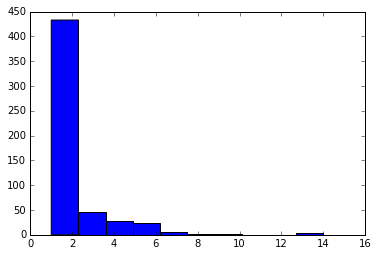

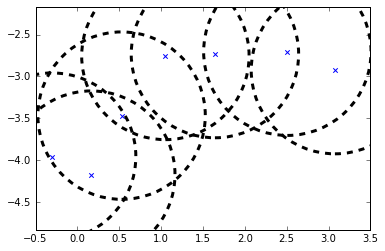

In [25]:
plt.hist(numNGBs)
index = list(np.logical_and(numNGBs>5,numNGBs<10)).index(1)

my_coords = np.array([xss[index],yss[index],zss[index]]).T


plt.figure()
plt.scatter(my_coords[:,0],my_coords[:,1],marker='x')
for (x,y,r) in zip(my_coords[:,0],my_coords[:,1],llss[index]):
    print x,y,r
    plt.gca().add_artist(plt.Circle((x,y),r,ls='--',lw=3,fill=None))
plt.axes().set_aspect('equal', 'datalim')


for coord in my_coords:
    dist = np.sum((my_coords-coord)**2,axis=1)/llss[index]**2
    print dist
print 'done'
print